# Import

In [ ]:
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory

# Data importeren

Importeren van de data uit drive,
vul de authorization code in die verkregen wordt via de link of er wordt al direct een scherm opgebracht waar je kan inloggen.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/Schilderijen-Classificeren_Arthur-Huys/datasets" "/content/datasets"

Mounted at /gdrive


In [ ]:
import shutil
shutil.unpack_archive('datasets/Picasso_Rubens_VanGogh_400_100_100.zip','.','zip')

# creëren datasets

Bij het creëren van deze datasets moet de class_mode verandert naar categorical omdat we nu met multi class data werken (3 verschillende labels).

In [ ]:
train_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_400_100_100/train",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

validation_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_400_100_100/validation",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

test_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_400_100_100/test",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

Found 1200 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


# Building model

In [ ]:
base_model = keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet",
    classes=3,
    classifier_activation="softmax")

base_model.trainable = True
for layer in base_model.layers[:-12]:
  layer.trainable = False

In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
     layers.RandomContrast(0.5,1.5)])

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

# Training model

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 0.6871 - accuracy: 0.8308

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 21s 401ms/step - loss: 0.6871 - accuracy: 0.8308 - val_loss: 0.9587 - val_accuracy: 0.8567
Epoch 2/30
38/38 [==============================] - 15s 365ms/step - loss: 0.2362 - accuracy: 0.9275 - val_loss: 0.3611 - val_accuracy: 0.9400
Epoch 3/30
38/38 [==============================] - 15s 368ms/step - loss: 0.1485 - accuracy: 0.9575 - val_loss: 0.3416 - val_accuracy: 0.9267
Epoch 4/30
38/38 [==============================] - 15s 370ms/step - loss: 0.1123 - accuracy: 0.9600 - val_loss: 0.3067 - val_accuracy: 0.9333
Epoch 5/30
38/38 [==============================] - 15s 370ms/step - loss: 0.0754 - accuracy: 0.9742 - val_loss: 0.2995 - val_accuracy: 0.9467
Epoch 6/30
38/38 [==============================] - 15s 371ms/step - loss: 0.0623 - accuracy: 0.9758 - val_loss: 0.2990 - val_accuracy: 0.9533
Epoch 7/30
38/38 [==============================] - 15s 371ms/step - loss: 0.0543 - accuracy: 0.9825 - val_loss: 0.2745 - val_accuracy: 0.9433
Epoch 8/30

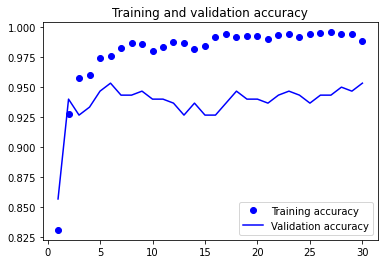

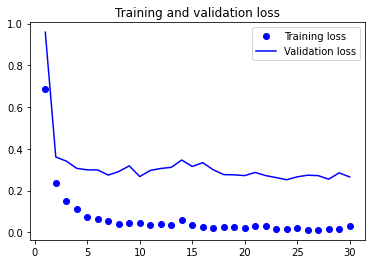

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Testing

Hier kunnen we weer zien dat de validation accuracy ongeveer gelijk blijf na de 40ste epoch.

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 4s 202ms/step - loss: 0.0590 - accuracy: 0.9800
Test accuracy: 0.980


In [ ]:
test_model.save("model_three_painters.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
